In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# 1. 数据增强
class SimCLRTransform:
    def __init__(self, size=28):
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(size=size, scale=(0.2, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([
                transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
            ], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor(),
        ])

    def __call__(self, x):
        return self.transform(x), self.transform(x)

In [2]:

# 2. 数据加载
train_dataset = datasets.FashionMNIST(
    root='./data',
    train=True,
    transform=SimCLRTransform(),
    download=True
)

train_loader = DataLoader(
    train_dataset,
    batch_size=256,
    shuffle=True,
    num_workers=8,
    drop_last=True,
    pin_memory=True
)


In [3]:
# 3. 模型定义
class Encoder(nn.Module):
    def __init__(self, feature_dim=128):
        super(Encoder, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.fc = nn.Linear(128, feature_dim)

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

class ProjectionHead(nn.Module):
    def __init__(self, input_dim=128, hidden_dim=128, output_dim=128):
        super(ProjectionHead, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

class SimCLR(nn.Module):
    def __init__(self, encoder, projection_head):
        super(SimCLR, self).__init__()
        self.encoder = encoder
        self.projection_head = projection_head

    def forward(self, x):
        h = self.encoder(x)
        z = self.projection_head(h)
        return F.normalize(z, dim=1)

In [4]:
# 4. 监督对比损失
def supervised_contrastive_loss(features, labels, temperature=0.5):
    """
    计算监督对比损失
    features: [2N, D] 特征向量
    labels: [2N] 标签
    temperature: 温度参数
    """
    device = features.device
    batch_size = features.shape[0]
    
    # 归一化特征
    features = F.normalize(features, dim=1)
    
    # 计算相似度矩阵
    similarity_matrix = torch.matmul(features, features.T) / temperature
    
    # 创建标签矩阵
    labels = labels.contiguous().view(-1, 1)
    mask = torch.eq(labels, labels.T).float().to(device)
    
    # 去除自身相似
    logits_mask = torch.ones_like(mask) - torch.eye(batch_size).to(device)
    mask = mask * logits_mask
    
    # 计算对数分数
    exp_sim = torch.exp(similarity_matrix) * logits_mask
    log_prob = similarity_matrix - torch.log(exp_sim.sum(1, keepdim=True))
    
    # 计算损失
    mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)
    
    loss = -mean_log_prob_pos
    loss = loss.mean()
    
    return loss

In [5]:
# 5. 训练设置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = Encoder()
projection_head = ProjectionHead()
model = SimCLR(encoder, projection_head).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 200

In [6]:
from tqdm.notebook import tqdm

In [7]:
# 6. 训练过程
model.train()
for epoch in tqdm(range(epochs)):
    
    total_loss = 0
    for (x_i, x_j), labels in train_loader:
        x_i = x_i.to(device, non_blocking=True)
        x_j = x_j.to(device, non_blocking=True)
        labels = labels.to(device)
        
        # 合并两个视图
        x = torch.cat([x_i, x_j], dim=0)  # 2N x C x H x W
        labels = torch.cat([labels, labels], dim=0)  # 2N
        
        # 提取特征
        features = model(x)  # 2N x D
        
        # 计算损失
        loss = supervised_contrastive_loss(features, labels, temperature=0.5)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    avg_loss = total_loss / len(train_loader)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [10/200], Loss: 5.1503
Epoch [20/200], Loss: 5.0942
Epoch [30/200], Loss: 5.0667
Epoch [40/200], Loss: 5.0413
Epoch [50/200], Loss: 5.0228
Epoch [60/200], Loss: 5.0113
Epoch [70/200], Loss: 5.0000
Epoch [80/200], Loss: 4.9977
Epoch [90/200], Loss: 4.9868
Epoch [100/200], Loss: 4.9835
Epoch [110/200], Loss: 4.9790
Epoch [120/200], Loss: 4.9767
Epoch [130/200], Loss: 4.9716
Epoch [140/200], Loss: 4.9704
Epoch [150/200], Loss: 4.9621
Epoch [160/200], Loss: 4.9620
Epoch [170/200], Loss: 4.9601
Epoch [180/200], Loss: 4.9566
Epoch [190/200], Loss: 4.9557
Epoch [200/200], Loss: 4.9544


In [8]:
# 7. 特征提取与可视化
# 加载测试集
test_transform = transforms.ToTensor()
test_dataset = datasets.FashionMNIST(
    root='./data',
    train=False,
    transform=test_transform,
    download=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=256,
    shuffle=False,
    num_workers=4
)

In [9]:
# 提取特征
model.eval()
features = []
labels = []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        h = model.encoder(x)
        features.append(h.cpu())
        labels.append(y)

features = torch.cat(features, dim=0).numpy()
labels = torch.cat(labels, dim=0).numpy()

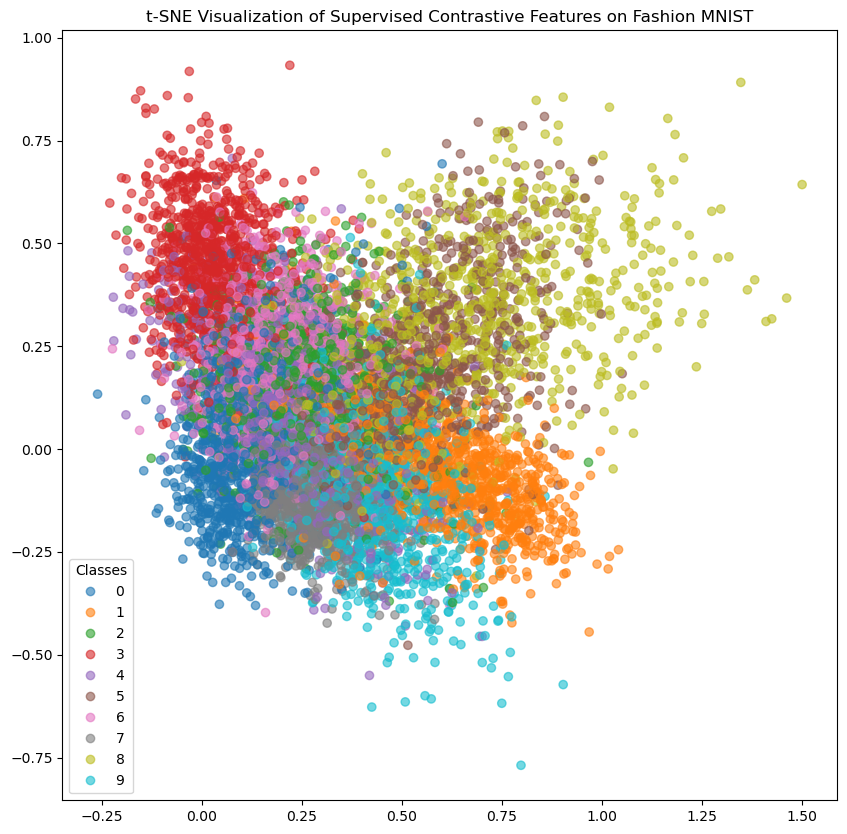

In [10]:
plt.figure(figsize=(10, 10))
scatter = plt.scatter(features[:,0], features[:,1], c=labels, cmap='tab10', alpha=0.6)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("t-SNE Visualization of Supervised Contrastive Features on Fashion MNIST")
plt.show()

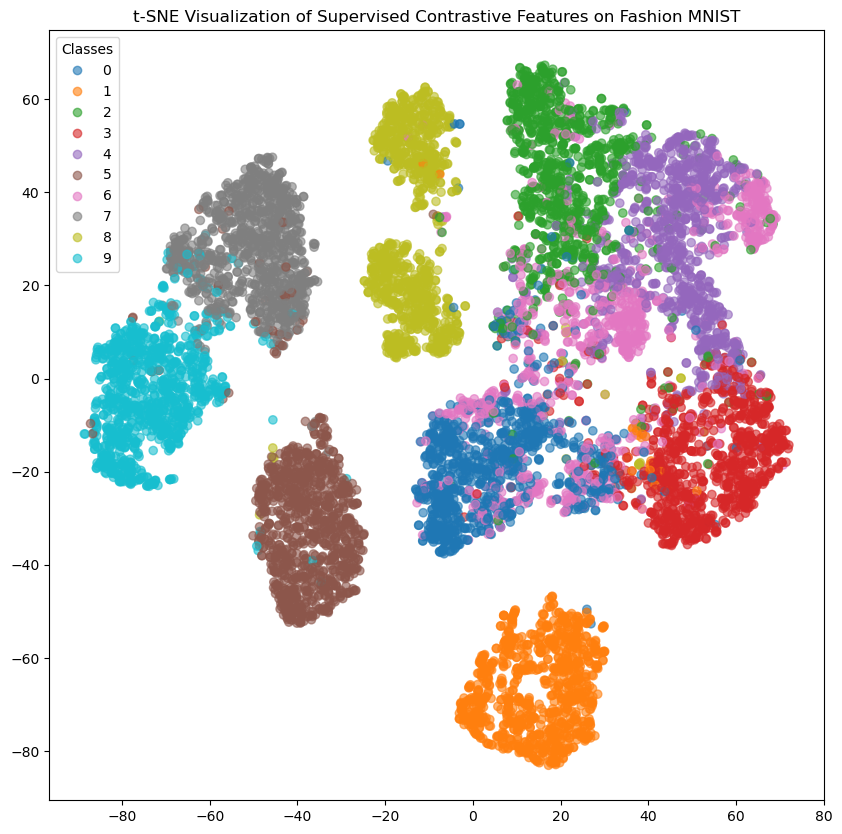

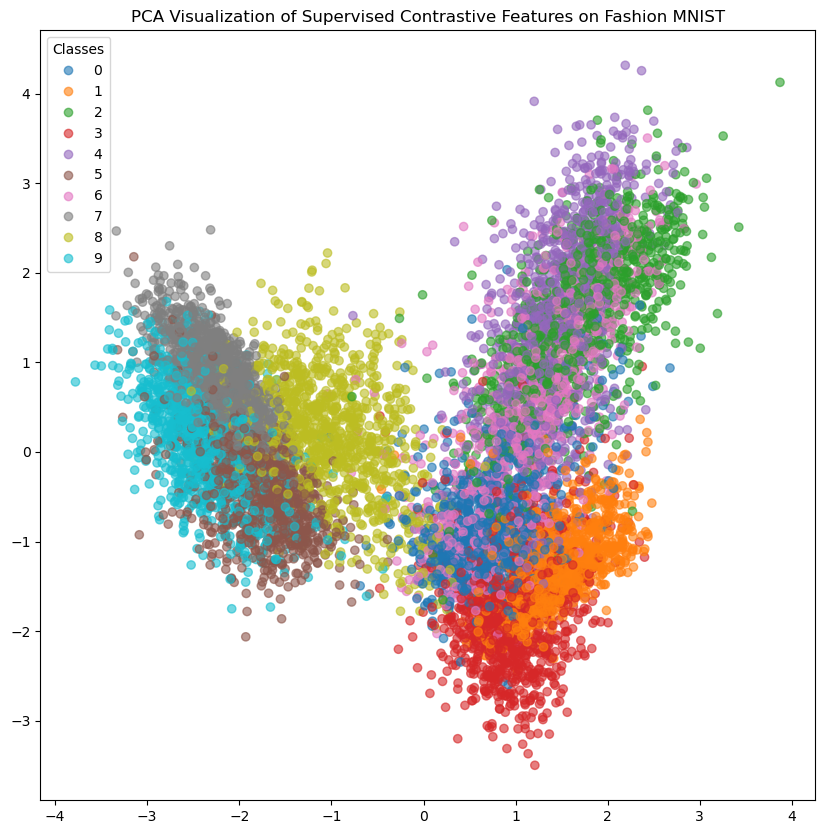

In [11]:
# t-SNE降维
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(features_tsne[:,0], features_tsne[:,1], c=labels, cmap='tab10', alpha=0.6)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("t-SNE Visualization of Supervised Contrastive Features on Fashion MNIST")
plt.show()

# PCA降维
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(features_pca[:,0], features_pca[:,1], c=labels, cmap='tab10', alpha=0.6)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("PCA Visualization of Supervised Contrastive Features on Fashion MNIST")
plt.show()